# Load Data

In [1]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import gsw

## Model

In [2]:
dir_mod = '/data/local/marine-training/data/MATPEL_05/cawo_out'
paths_mod = []
for file in os.listdir(dir_mod):
    if file.endswith('nc') and 'cawo' in file:
        paths_mod.append(os.path.join(dir_mod, file))
paths_mod.sort()
ds_mod = xr.open_mfdataset(paths_mod, chunks='auto')

## Argo

In [3]:
path_argo_nc = '/data/local/marine-training/data/MATPEL_05/argo_data/nc_argo/GL_PR_PF_2902800.nc'
ds_argo = xr.open_dataset(path_argo_nc)

## Drifter

In [4]:
path_drifter_csv = '/data/local/marine-training/data/MATPEL_05/drifter_data/drifter_6hour_qc_f5dd_5de7_fd9d.csv'
df_drifter = pd.read_csv(path_drifter_csv)

# Verifikasi

## Verifikasi menggunakan data Argo float

### Menyeleksi Data Berdasarkan QC dan Wilayah Indonesia

In [5]:
ds_argo_filtered = (ds_argo
                    .where(ds_argo['PRES_ADJUSTED_QC'] == 1)
                    .where(ds_argo['TEMP_ADJUSTED_QC'] == 1)
                    .where(ds_argo['PSAL_ADJUSTED_QC'] == 1)
                   )

t_start = pd.to_datetime("2024-02-01")
t_end = pd.to_datetime("2025-03-31")
ext_indo = [90, 145, -15, 15]

# 1. Mengambil nilai dari dimensi
lat = ds_argo_filtered['LATITUDE'].values
lon = ds_argo_filtered['LONGITUDE'].values
tm = pd.to_datetime(ds_argo_filtered['TIME'].values)

# 2. Buat mask lokasi: hanya posisi dalam batas wilayah Indonesia
mask_pos = (lon >= ext_indo[0]) & (lon <= ext_indo[1]) & (lat >= ext_indo[2]) & (lat <= ext_indo[3])

# 3. Buat mask waktu: hanya waktu dalam rentang yang ditentukan
mask_tm = (tm >= t_start) & (tm <= t_end)

# 4. Gabungkan kedua mask (lokasi dan waktu)
mask_combined = mask_pos & mask_tm

# 5. Indeks data yang lolos seleksi
valid_indices = np.where(mask_combined)[0]
# print(f"Indeks/cycle yang lolos seleksi: {valid_indices}")

ds_argo_filtered = ds_argo_filtered.sel(TIME=mask_combined, LATITUDE=mask_combined, LONGITUDE=mask_combined, POSITION=valid_indices)
ds_argo_filtered['POSITION'] = ('TIME', ds_argo['POSITION'].values[valid_indices])
ds_argo_filtered

<xarray.Dataset> Size: 2MB
Dimensions:                   (TIME: 60, DEPTH: 103, POSITION: 60,
                               LATITUDE: 60, LONGITUDE: 60)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 480B 2024-02-05T01:30:26 ...
  * LATITUDE                  (LATITUDE) float32 240B 4.764 4.568 ... 4.038
  * LONGITUDE                 (LONGITUDE) float32 240B 130.1 129.8 ... 131.1
    POSITION                  (TIME) int64 480B 159 160 161 162 ... 216 217 218
Dimensions without coordinates: DEPTH
Data variables: (12/23)
    TIME_QC                   (TIME, DEPTH) float32 25kB 1.0 1.0 1.0 ... nan nan
    POSITION_QC               (POSITION, TIME, DEPTH) float32 1MB 1.0 ... nan
    DC_REFERENCE              (TIME, DEPTH) object 49kB b'93359759' ... nan
    DIRECTION                 (TIME, DEPTH) object 49kB b'A' b'A' ... nan nan
    VERTICAL_SAMPLING_SCHEME  (TIME, DEPTH) object 49kB b'Synthetic sampling'...
    PRES                      (TIME, DEPTH) float32 25kB 0.0 0.6 1.9 ... nan nan
    ...                        ...
    PSAL                      (TIME, DEPTH) float64 49kB 34.02 34.06 ... nan nan
    PSAL_QC                   (TIME, DEPTH) float32 25kB 1.0 1.0 1.0 ... nan nan
    PSAL_ADJUSTED             (TIME, DEPTH) float64 49kB 34.02 34.06 ... nan nan
    PSAL_ADJUSTED_QC          (TIME, DEPTH) float32 25kB 1.0 1.0 1.0 ... nan nan
    PSAL_ADJUSTED_DM          (TIME, DEPTH) object 49kB b'D' b'D' ... nan nan
    PSAL_ADJUSTED_ERROR       (TIME, DEPTH) float64 49kB 0.009 0.009 ... nan nan
Attributes: (12/49)
    data_type:                      OceanSITES vertical profile
    format_version:                 1.4
    platform_code:                  2902800
    institution:                    First Institute of Oceanography - Ministr...
    institution_edmo_code:          4640
    site_code:                       
    ...                             ...
    last_date_observation:          2025-04-05T01:30:25Z
    last_latitude_observation:      4.24300
    last_longitude_observation:     130.82900
    date_update:                    2025-04-15T09:50:18Z
    history:                        2025-04-15T09:50:18Z : Creation
    data_mode:                      M

### Menyeleksi berdasarkan dimensi model

In [6]:
# Ambil data
pressure = ds_argo_filtered["PRES_ADJUSTED"].values        # (n_profile, n_levels)
latitude = ds_argo_filtered["LATITUDE"].values             # (n_profile,)
longitude = ds_argo_filtered["LONGITUDE"].values           # (n_profile,)
temperature = ds_argo_filtered["TEMP_ADJUSTED"].values     # (n_profile, n_levels)
salinity = ds_argo_filtered['PSAL_ADJUSTED'].values        # (n_profile, n_levels)

# Target kedalaman yang ingin diambil
target_depths = np.abs(ds_mod.depth.values)

# Konversi tekanan ke kedalaman per profil
n_profiles = pressure.shape[0]
depth = np.empty_like(pressure)

for i in range(n_profiles):
    depth[i, :] = -gsw.z_from_p(pressure[i, :], latitude[i])

# Fungsi untuk ambil nilai variabel di kedalaman terdekat
def get_nearest_profile_values(var, depth_arr, target_depths):
    result = []
    for prof_idx in range(var.shape[0]):
        prof_values = []
        for td in target_depths:
            # Hanya pertimbangkan nilai yang tidak NaN
            valid_indices = ~np.isnan(depth_arr[prof_idx]) & ~np.isnan(var[prof_idx])
            if not np.any(valid_indices):
                prof_values.append(np.nan)  # Jika semua nilai NaN, tambahkan NaN
                continue
            valid_depth = depth_arr[prof_idx][valid_indices]
            valid_var = var[prof_idx][valid_indices]
            # Temukan indeks dengan nilai kedalaman terdekat
            idx = (np.abs(valid_depth - td)).argmin()
            prof_values.append(valid_var[idx])
        result.append(prof_values)
    return np.array(result)

# Ambil suhu pada kedalaman target
temp_at_target_depths = get_nearest_profile_values(temperature, depth, target_depths)
sali_at_target_depths = get_nearest_profile_values(salinity, depth, target_depths)
press_at_target_depths = get_nearest_profile_values(pressure, depth, target_depths)

# Buat dataframe untuk suhu pada kedalaman target
df_temp_at_model_depths = pd.DataFrame(temp_at_target_depths, columns=target_depths)
df_sali_at_model_depths = pd.DataFrame(sali_at_target_depths, columns=target_depths)
df_press_at_model_depths = pd.DataFrame(press_at_target_depths, columns=target_depths)

### Mengkonversi nilai temperatur in-situ menjadi temperatur potensial

In [7]:
# Ambil suhu, salinitas, dan tekanan dari DataFrame
temp = df_temp_at_model_depths.values            # (n_profiles, n_depths)
sali = df_sali_at_model_depths.values            # (n_profiles, n_depths)
press = df_press_at_model_depths.values          # (n_profiles, n_depths)

# Ambil latitude dan longitude dari profil
latitude = ds_argo_filtered["LATITUDE"].values   # (n_profiles,)
longitude = ds_argo_filtered["LONGITUDE"].values # (n_profiles,)

# Ukuran
n_profiles, n_depths = temp.shape

# Perluas latitude dan longitude agar sesuai shape (n_profiles, n_depths)
lat_2d = np.repeat(latitude[:, np.newaxis], n_depths, axis=1)
lon_2d = np.repeat(longitude[:, np.newaxis], n_depths, axis=1)

# Konversi ke Absolute Salinity (dari Practical Salinity)
SA = gsw.SA_from_SP(sali, press, lon_2d, lat_2d)

# Hitung Potential Temperature (referensi ke permukaan laut, 0 dbar)
pt = gsw.pt_from_t(SA, temp, press, p_ref=0)

# Buat DataFrame hasil
df_pt_at_model_depths = pd.DataFrame(pt, columns=target_depths)
df_pt_at_model_depths['TIME'] = pd.to_datetime(ds_argo_filtered['TIME'].values)
df_pt_at_model_depths.set_index('TIME', inplace=True)
df_pt_at_model_depths = df_pt_at_model_depths.transpose()
df_pt_at_model_depths.index.name = 'Depth (m)'
df_pt_at_model_depths.columns.name = 'Time'

### Ambil data model

In [8]:
# Ekstrak Data model berdasarkan lat/lon/time data obs
latitude = ds_argo_filtered['LATITUDE'].values
longitude = ds_argo_filtered['LONGITUDE'].values
argo_time = pd.to_datetime(ds_argo_filtered['TIME'].values)

mod_temps_val = []

for i, dt in enumerate(argo_time):
    argLat = latitude[i]
    argLon = longitude[i]
    ds0 = ds_mod.sel(date=dt, lat=argLat, lon=argLon, method='nearest')
    mod_temps_val.append(ds0['sw_temp'].values)
    
# Buat dataframe untuk suhu pada kedalaman target dari data model
df_pt_mod = pd.DataFrame(mod_temps_val, columns=np.abs(ds_mod.depth.values))
df_pt_mod['TIME'] = argo_time
df_pt_mod.set_index('TIME', inplace=True)
df_pt_mod = df_pt_mod.transpose()
df_pt_mod.index.name = 'Depth (m)'
df_pt_mod.columns.name = 'Time'


### Hitung parameter verifikasi

In [9]:
# Verifikasi temperatur potensial:
from mods import verification_metrics
metrics_verif_temp = verification_metrics(df_pt_at_model_depths, df_pt_mod)
print("Verifikasi Suhu:")
for k, v in metrics_verif_temp.items():
    print(f"{k}: {v:.3f}")


Verifikasi Suhu:
Correlation: 0.996
MAPE (%): 4.088
Bias: -0.070
RMSE: 1.019
Std Obs: 10.804
Std Model: 10.685


## Verifikasi menggunakan data Drifter

### Menyeleksi data drifter

In [10]:
# Data sudah terseleksi saat akuisisi, hanya perlu menyesuaikan format data dan merapihkan data tabel
# Ambil baris pertama sebagai header yang benar
new_header = np.asarray(df_drifter.columns)
df_drifter_adjs = df_drifter[1:]
df_drifter_adjs.columns = new_header

# Drop rows dengan ID, latitude, atau longitude kosong
df_drifter_adjs = df_drifter_adjs.dropna(subset=["ID", "latitude", "longitude"])

# Konversi tipe data yang diperlukan
df_drifter_adjs["ID"] = df_drifter_adjs["ID"].astype(int)
df_drifter_adjs["latitude"] = df_drifter_adjs["latitude"].astype(float)
df_drifter_adjs["longitude"] = df_drifter_adjs["longitude"].astype(float)
df_drifter_adjs["time"] = pd.to_datetime(df_drifter_adjs["time"], format="%Y-%m-%dT%H:%M:%SZ")
df_drifter_adjs["start_date"] = pd.to_datetime(df_drifter_adjs["start_date"], format="%Y-%m-%dT%H:%M:%SZ")
df_drifter_adjs["deploy_date"] = pd.to_datetime(df_drifter_adjs["deploy_date"], format="%Y-%m-%dT%H:%M:%SZ")
df_drifter_adjs["end_date"] = pd.to_datetime(df_drifter_adjs["end_date"], format="%Y-%m-%dT%H:%M:%SZ")
df_drifter_adjs["drogue_lost_date"] = pd.to_datetime(df_drifter_adjs["drogue_lost_date"], format="%Y-%m-%dT%H:%M:%SZ")

# Ambil ID unik
unique_ids = df_drifter_adjs["ID"].unique()

### Memilih data berdasarkan ID

In [11]:
df_drifter2verif = df_drifter_adjs.loc[df_drifter_adjs['ID'] == 300234061473430][['ID', 'time', 'latitude', 'longitude', 'sst']]
df_drifter2verif['time'] = pd.to_datetime(df_drifter2verif['time']).dt.normalize()  # Atau .dt.strftime('%Y-%m-%d')
df_drifter2verif.set_index(['time'], inplace=True)

### Ambil data model

In [12]:
# Ekstrak Data model berdasarkan lat/lon/time data drifter
lons, lats = df_drifter2verif['longitude'].values, df_drifter2verif['latitude'].values
drf_time = pd.to_datetime(df_drifter2verif.index.values)

mod_temps_val = []
mod_tms = []

for i, dt in enumerate(drf_time):
    drfLat = lats[i]
    drfLon = lons[i]
    ds0 = ds_mod.sel(date=dt.strftime('%Y-%m-%d'), depth=0., lat=drfLat, lon=drfLon, method='nearest')
    mod_temps_val.append(ds0['sw_temp'].values)
    mod_tms.append(ds0.date.values)
    
# Buat dataframe untuk suhu pada kedalaman target dari data model
df_mod_temp = pd.DataFrame(
    data={
        'time': pd.to_datetime(mod_tms),
        'latitude': lats,
        'longitude': lons,
        'sst': mod_temps_val
    }
)
df_mod_temp.set_index(['time'], inplace=True)

In [13]:
df_drifter2verif['sst'] = df_drifter2verif['sst'].astype(float)
df_mod_temp['sst'] = df_mod_temp['sst'].astype(float)

metrics_verif_temp_drifter = verification_metrics(df_drifter2verif, df_mod_temp)
print("Verifikasi Suhu:")
for k, v in metrics_verif_temp_drifter.items():
    print(f"{k}: {v:.3f}")


Verifikasi Suhu:
Correlation: 1.000
MAPE (%): 0.632
Bias: 0.184
RMSE: 0.392
Std Obs: 66.363
Std Model: 66.299


# Visualisasi hasil verifikasi

## Membuat Taylor Diagram untuk visualisasi verifikasi Model dan Argo

In [14]:
from mods import TaylorDiagram
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

In [15]:
ccorr = 0.996
stdv_mod = 10.685
stdv_arg = 10.804

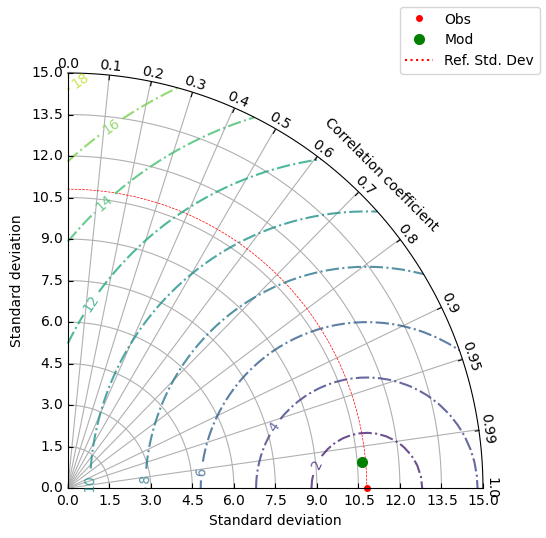

In [16]:
fig = plt.figure(figsize=(5.5,5.5))
dia = TaylorDiagram(stdv_arg, fig=fig, rect=111, label='', grid=True)
dia.add_sample(stdv_arg, 1, label="Obs", marker=".", ls="", mec="red", mfc="red", mew=2)
dia.add_sample(stdv_mod, ccorr, label=f"Mod", marker="o", ls="", mfc="green", mec="none", markersize=8)              
ref_line = Line2D([0], [0], color="red", linestyle=":")
handles = dia.samplePoints + [ref_line]
labels = [p.get_label() for p in dia.samplePoints] + ["Ref. Std. Dev"]
fig.legend(handles[1:], labels[1:], numpoints=1, prop=dict(size="medium"))
contours = dia.add_contours()
plt.clabel(contours, inline=1, fontsize=10)
plt.show()